In [1]:
import json
import re
import time

import awkward as ak
import hist
import mplhep
import numpy as np
import utils
import vector
from awkward._nplikes.dispatch import nplike_of_obj
from awkward._nplikes.virtual import VirtualArray
from coffea import processor
from coffea.nanoevents import BaseSchema, NanoEventsFactory
from matplotlib import pyplot as plt
from utils import infofile  # contains cross-section information

vector.register_awkward()

utils.clean_up()  # delete output from previous runs of notebook (optional)
utils.set_logging()  # configure logging output

/Users/iason/Dropbox/work/coffea_dev/coffea/src/coffea/nanoevents/schemas/edm4hep.py:7: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


In [2]:
# information for histograms
bin_edge_low = 80  # 80 GeV
bin_edge_high = 250  # 250 GeV
num_bins = 34


def get_xsec_weight(sample: str) -> float:
    """Returns normalization weight for a given sample."""
    lumi = 10_000  # pb^-1
    xsec_map = infofile.infos[sample]  # dictionary with event weighting information
    xsec_weight = (lumi * xsec_map["xsec"]) / (xsec_map["sumw"] * xsec_map["red_eff"])
    return xsec_weight


def lepton_filter(lep_charge, lep_type):
    """Filters leptons: sum of charges is required to be 0, and sum of lepton types 44/48/52.
    Electrons have type 11, muons have 13, so this means 4e/4mu/2e2mu.
    """
    sum_lep_charge = ak.sum(lep_charge, axis=1)
    sum_lep_type = ak.sum(lep_type, axis=1)
    good_lep_type = ak.any([sum_lep_type == 44, sum_lep_type == 48, sum_lep_type == 52], axis=0)
    return ak.all([sum_lep_charge == 0, good_lep_type], axis=0)


class HZZAnalysis(processor.ProcessorABC):
    """The coffea processor used in this analysis."""

    def __init__(self):
        pass

    def process(self, events):
        vector.register_awkward()
        # type of dataset being processed, provided via metadata (comes originally from fileset)
        dataset_category = events.metadata["dataset_name"]

        # apply a cut to events, based on lepton charge and lepton type
        events = events[lepton_filter(events.lep_charge, events.lep_typeid)]

        # construct lepton four-vectorsadd
        leptons = ak.zip(
            {"pt": events.lep_pt, "eta": events.lep_eta, "phi": events.lep_phi, "energy": events.lep_energy},
            with_name="Momentum4D",
        )

        # calculate the 4-lepton invariant mass for each remaining event
        # this could also be an expensive calculation using external tools
        mllll = (leptons[:, 0] + leptons[:, 1] + leptons[:, 2] + leptons[:, 3]).mass / 1000

        # creat histogram holding outputs, for data just binned in m4l
        mllllhist_data = hist.Hist.new.Reg(
            num_bins,
            bin_edge_low,
            bin_edge_high,
            name="mllll",
            label=r"$\mathrm{m_{4l}}$ [GeV]",
        ).Weight()  # using weighted storage here for plotting later, but not needed

        # three histogram axes for MC: m4l, category, and variation (nominal and
        # systematic variations)
        mllllhist_MC = (
            hist.Hist.new.Reg(
                num_bins,
                bin_edge_low,
                bin_edge_high,
                name="mllll",
                label=r"$\mathrm{m_{4l}}$ [GeV]",
            )
            .StrCat(["ggH", "Other"], name="dataset")
            .StrCat(
                ["nominal", "scaleFactorUP", "scaleFactorDOWN", "m4lUP", "m4lDOWN"],
                name="variation",
            )
            .Weight()
        )

        if dataset_category == "Data":
            # create and fill a histogram for m4l
            mllllhist_data.fill(mllll=mllll)

        else:
            # extract the sample name from the filename to calculate x-sec weight
            sample = re.findall(r"mc_\d+\.(.+)\.4lep", events.metadata["filename"])[0]
            basic_weight = get_xsec_weight(sample) * events.mcWeight
            totalWeights = basic_weight * events.scaleFactor

            # calculate systematic variations for weight
            totalWeightsUp = basic_weight * events.scaleFactorUP
            totalWeightsDown = basic_weight * events.scaleFactorDOWN

            # create and fill weighted histograms for m4l: nominal and variations
            mllllhist_MC.fill(
                mllll=mllll,
                dataset=dataset_category,
                variation="nominal",
                weight=totalWeights,
            )

            # scale factor variations
            mllllhist_MC.fill(
                mllll=mllll,
                dataset=dataset_category,
                variation="scaleFactorUP",
                weight=totalWeightsUp,
            )
            mllllhist_MC.fill(
                mllll=mllll,
                dataset=dataset_category,
                variation="scaleFactorDOWN",
                weight=totalWeightsDown,
            )

            # variation in 4-lepton invariant mass
            mllllhist_MC.fill(
                mllll=mllll * 1.01,
                dataset=dataset_category,
                variation="m4lUP",
                weight=totalWeights,
            )
            mllllhist_MC.fill(
                mllll=mllll * 0.99,
                dataset=dataset_category,
                variation="m4lDOWN",
                weight=totalWeights,
            )

        return {"data": mllllhist_data, "MC": mllllhist_MC}

    def postprocess(self, accumulator):
        pass

In [3]:
%%time


# def virtualize(array, form_key):
#     def generate():
#         print(f"Generating {form_key}")
#         return array

#     return VirtualArray(nplike_of_obj(array), array.shape, array.dtype, generate)


# def make_events(file, schemaclass=BaseSchema):
#     access_log = []
#     events = NanoEventsFactory.from_root(
#         {file: "mini"},
#         mode="eager",
#         schemaclass=schemaclass,
#         metadata={"dataset_name": "ggH", "filename": file},
#     ).events()
#     events["lep_energy"] = events.lep_E
#     events["lep_typeid"] = events.lep_type
#     events["scaleFactor"] = (
#         events.scaleFactor_ELE * events.scaleFactor_MUON * events.scaleFactor_LepTRIGGER * events.scaleFactor_PILEUP
#     )
#     events["scaleFactorUP"] = events.scaleFactor * 1.1
#     events["scaleFactorDOWN"] = events.scaleFactor * 0.9
#     behavior = events.behavior
#     attrs = events.attrs
#     form, length, container = ak.to_buffers(events)
#     new_form = events.layout.form_with_key_path()
#     new_container = {}
#     for old_key, new_key in zip(form.expected_from_buffers().keys(), new_form.expected_from_buffers().keys()):
#         new_container[new_key] = container[old_key]
#     with open("form.json", "w") as f:
#         json.dump(form.to_dict(), f, indent=2)
#     virtual_container = {key: virtualize(buffer, key) for key, buffer in new_container.items()}
#     events = ak.from_buffers(new_form, length, virtual_container, behavior=behavior)
#     events.attrs["@original_array"] = events
#     print("-" * 100)
#     return events, access_log


def make_events(file, schemaclass=BaseSchema):
    access_log = []
    events = NanoEventsFactory.from_root(
        {file: "mini"},
        mode="virtual",
        schemaclass=schemaclass,
        metadata={"dataset_name": "ggH", "filename": file},
        access_log=access_log,
    ).events()
    events["lep_energy"] = events.lep_E
    events["lep_typeid"] = events.lep_type
    events["scaleFactor"] = (
        events.scaleFactor_ELE * events.scaleFactor_MUON * events.scaleFactor_LepTRIGGER * events.scaleFactor_PILEUP
    )
    events["scaleFactorUP"] = events.scaleFactor * 1.1
    events["scaleFactorDOWN"] = events.scaleFactor * 0.9
    return events, access_log


events, access_log = make_events("http://xrootd-local.unl.edu:1094//store/user/AGC/ATLAS_HZZ/mc_345060.ggH125_ZZ4lep.4lep.root")
access_log

CPU times: user 403 ms, sys: 132 ms, total: 535 ms
Wall time: 7.9 s


['scaleFactor_ELE',
 'scaleFactor_MUON',
 'scaleFactor_LepTRIGGER',
 'scaleFactor_PILEUP']

In [4]:
processor_instance = HZZAnalysis()
t0 = time.monotonic()
all_histograms = processor_instance.process(events)
exec_time = time.monotonic() - t0
print(f"\nexecution took {exec_time:.2f} seconds")
access_log


execution took 5.94 seconds


['scaleFactor_ELE',
 'scaleFactor_MUON',
 'scaleFactor_LepTRIGGER',
 'scaleFactor_PILEUP',
 'lep_charge',
 'lep_charge',
 'lep_type',
 'lep_type',
 'lep_pt',
 'lep_eta',
 'lep_phi',
 'lep_E',
 'lep_pt',
 'lep_eta',
 'lep_phi',
 'lep_E',
 'mcWeight']

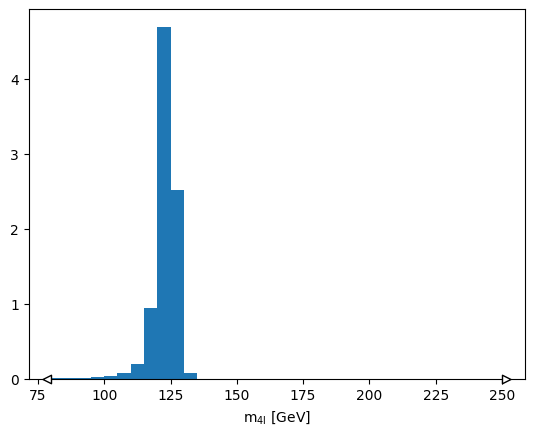

In [5]:
# plot histograms with mplhep & hist
hist.Hist.plot1d(
    all_histograms["MC"][:, "ggH", "nominal"],
    histtype="fill",
);